# Modeling

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [47]:
# Load data
df = pd.read_csv("../data/processed_dataset.csv")

# Pisahkan fitur dan label
X = df.drop(columns=['cooler', 'valve', 'leakage', 'acc', 'stable'])
feature_names = X.columns

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Simpan scaler dan feature_names untuk deployment
joblib.dump(scaler, "../models/scaler.pkl")
joblib.dump(feature_names, "../models/feature_names.pkl")

['../models/feature_names.pkl']

In [39]:
def train_model(X, y, model_name="RandomForest"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if model_name == "RandomForest":
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == "XGBoost":
        model = XGBClassifier(eval_metric='mlogloss')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n==== {model_name} for Target ====")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return model

## Model Random Forest

In [40]:
targets = ['cooler', 'valve', 'leakage', 'acc']
models = {}

for target in targets:
    print(f"\n--- Training model for: {target} ---")
    y = df[target]
    model = train_model(X_scaled, y, model_name="RandomForest")
    models[target] = model

# Save models
for target, model in models.items():
    joblib.dump(model, f"../models/{target}_model.pkl")
    print(f"Model for {target} saved as models/{target}_model.pkl")


--- Training model for: cooler ---

==== RandomForest for Target ====
[[152   0   0]
 [  0 135   0]
 [  0   1 153]]
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       152
          20       0.99      1.00      1.00       135
         100       1.00      0.99      1.00       154

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441


--- Training model for: valve ---

==== RandomForest for Target ====
[[ 88   0   0   0]
 [  0  66   1   0]
 [  0   0  80   0]
 [  1   0   0 205]]
              precision    recall  f1-score   support

          73       0.99      1.00      0.99        88
          80       1.00      0.99      0.99        67
          90       0.99      1.00      0.99        80
         100       1.00      1.00      1.00       206

    accuracy                           1.00       441
   macro avg       0.99      

In [41]:
# Pastikan fitur sama seperti saat training
feature_names = df.drop(columns=['cooler', 'valve', 'leakage', 'acc', 'stable']).columns

def plot_feature_importances(model, feature_names, top_n=15, title=''):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1][:top_n]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices])
    plt.title(f"Top {top_n} Feature Importances - {title}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

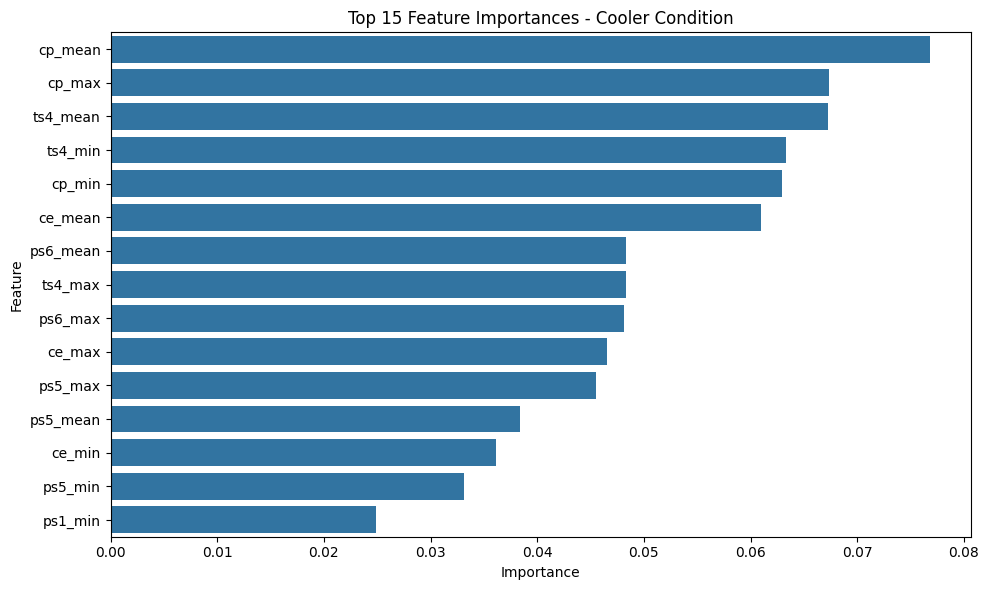

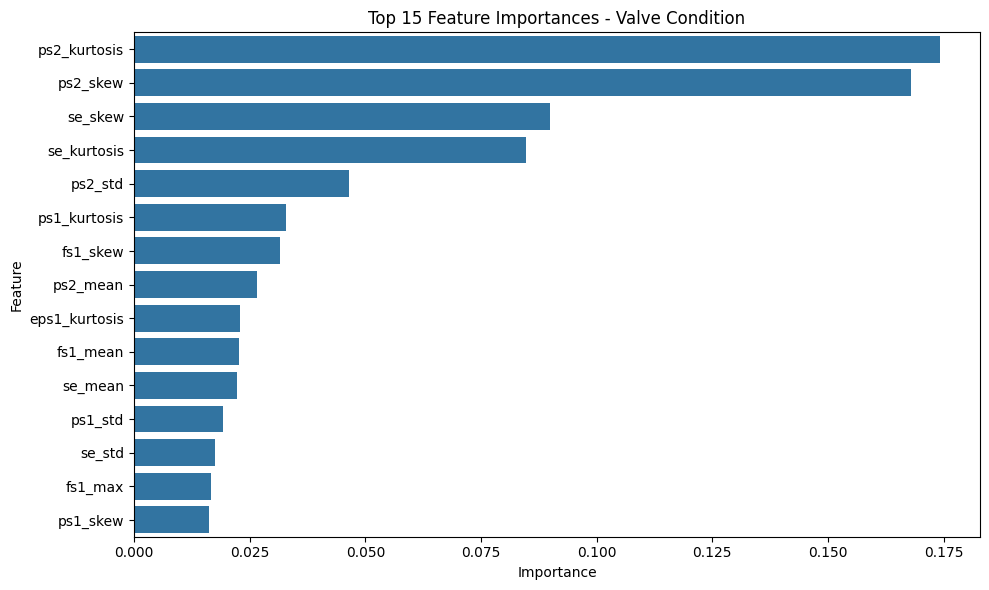

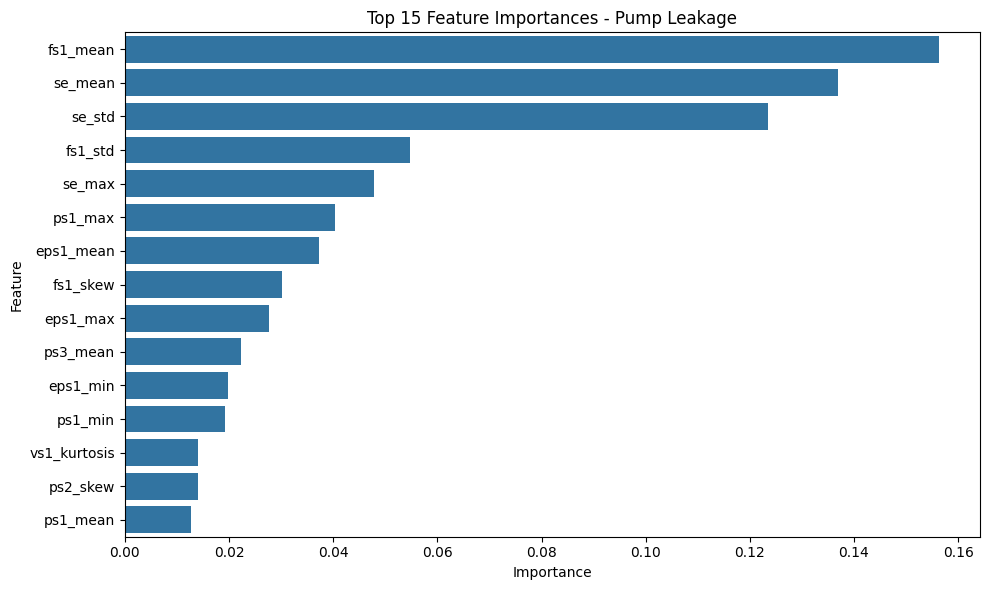

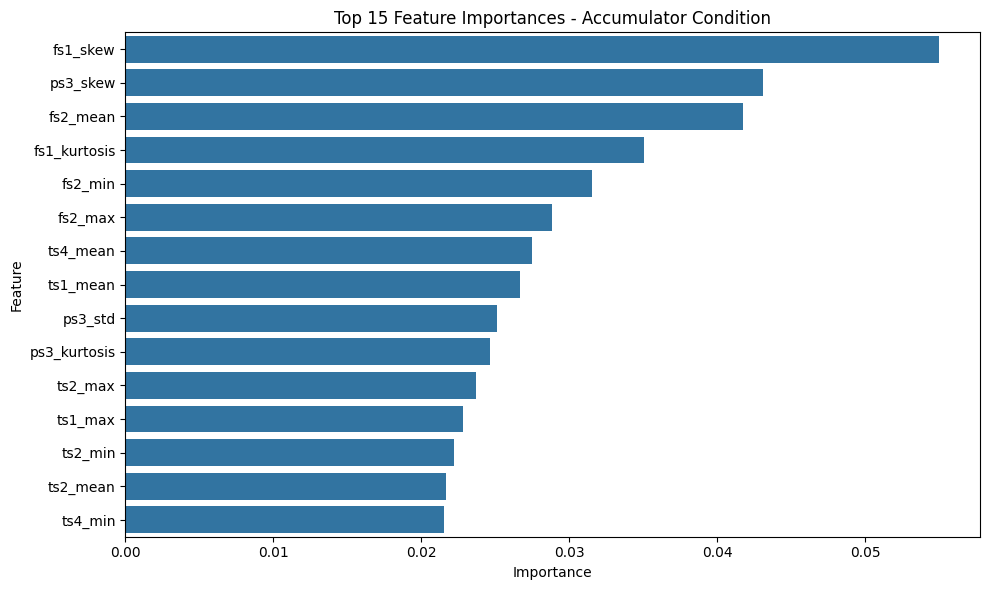

In [42]:
plot_feature_importances(models['cooler'], feature_names, title='Cooler Condition')
plot_feature_importances(models['valve'], feature_names, title='Valve Condition')
plot_feature_importances(models['leakage'], feature_names, title='Pump Leakage')
plot_feature_importances(models['acc'], feature_names, title='Accumulator Condition')

In [43]:
# Simpan feature importance ke CSV untuk setiap target
for target in models:
    importances = models[target].feature_importances_
    feature_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    feature_imp_df.to_csv(f"../models/{target}_feature_importance.csv", index=False)
    print(f"Feature importance untuk {target} disimpan di ../models/{target}_feature_importance.csv")

Feature importance untuk cooler disimpan di ../models/cooler_feature_importance.csv
Feature importance untuk valve disimpan di ../models/valve_feature_importance.csv
Feature importance untuk leakage disimpan di ../models/leakage_feature_importance.csv
Feature importance untuk acc disimpan di ../models/acc_feature_importance.csv


## Model XGBoost

In [44]:
targets = ['cooler', 'valve', 'leakage', 'acc']
models = {}
encoders = {}

for target in targets:
    print(f"\n--- Training model for: {target} ---")
    y = df[target]
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    encoders[target] = le
    model = train_model(X_scaled, y_encoded, model_name="XGBoost")
    models[target] = model

    # Evaluasi dengan label asli
    y_pred = model.predict(X_scaled)
    y_pred_label = le.inverse_transform(y_pred)
    print(f"Contoh prediksi label asli untuk {target}:", y_pred_label[:10])

# Save models dan encoders jika perlu
for target, model in models.items():
    joblib.dump(model, f"../models/{target}_XGB.pkl")
    joblib.dump(encoders[target], f"../models/{target}_encoder.pkl")
    print(f"Model dan encoder untuk {target} disimpan.")


--- Training model for: cooler ---

==== XGBoost for Target ====
[[152   0   0]
 [  0 135   0]
 [  0   0 154]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       152
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00       154

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441

Contoh prediksi label asli untuk cooler: [3 3 3 3 3 3 3 3 3 3]

--- Training model for: valve ---

==== XGBoost for Target ====
[[ 88   0   0   0]
 [  0  66   1   0]
 [  0   3  75   2]
 [  0   0   1 205]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       0.96      0.99      0.97        67
           2       0.97      0.94      0.96        80
           3       0.99      1.00      0.99       206

    accuracy                  

In [45]:
# Pastikan fitur sama seperti saat training
feature_names = df.drop(columns=['cooler', 'valve', 'leakage', 'acc', 'stable']).columns

def plot_feature_importances(model, feature_names, top_n=15, title=''):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1][:top_n]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices])
    plt.title(f"Top {top_n} Feature Importances - {title}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

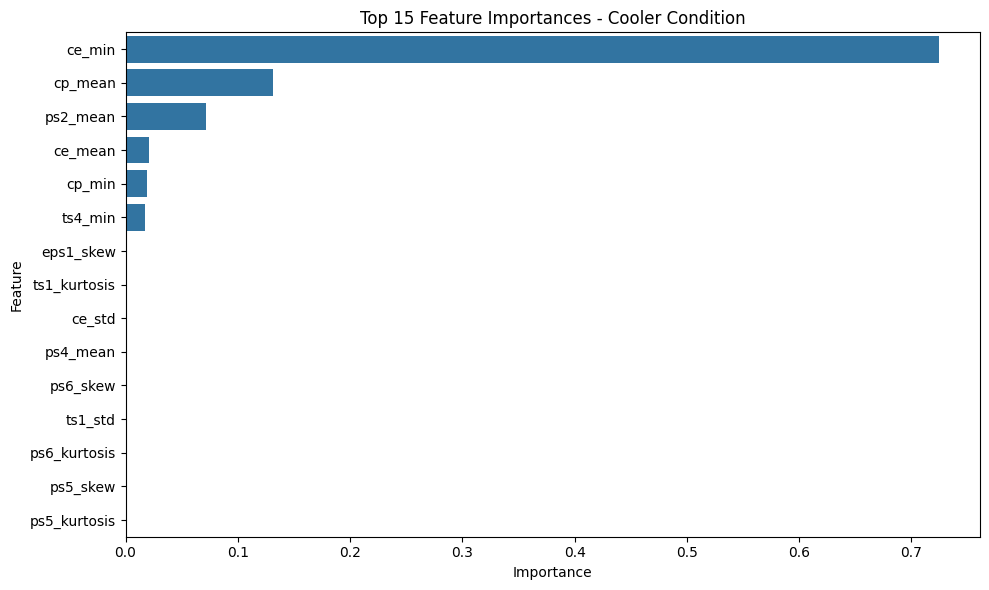

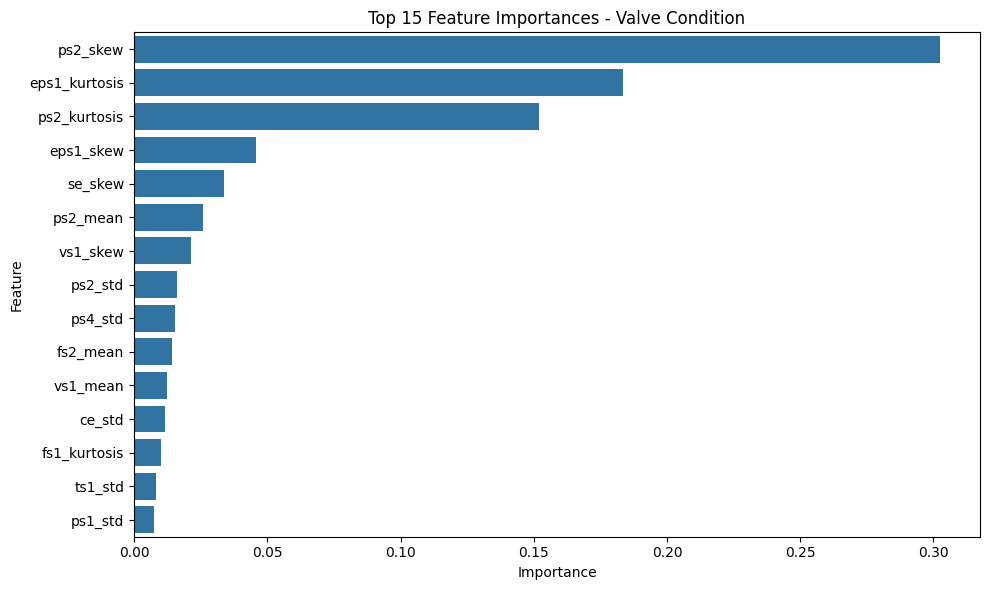

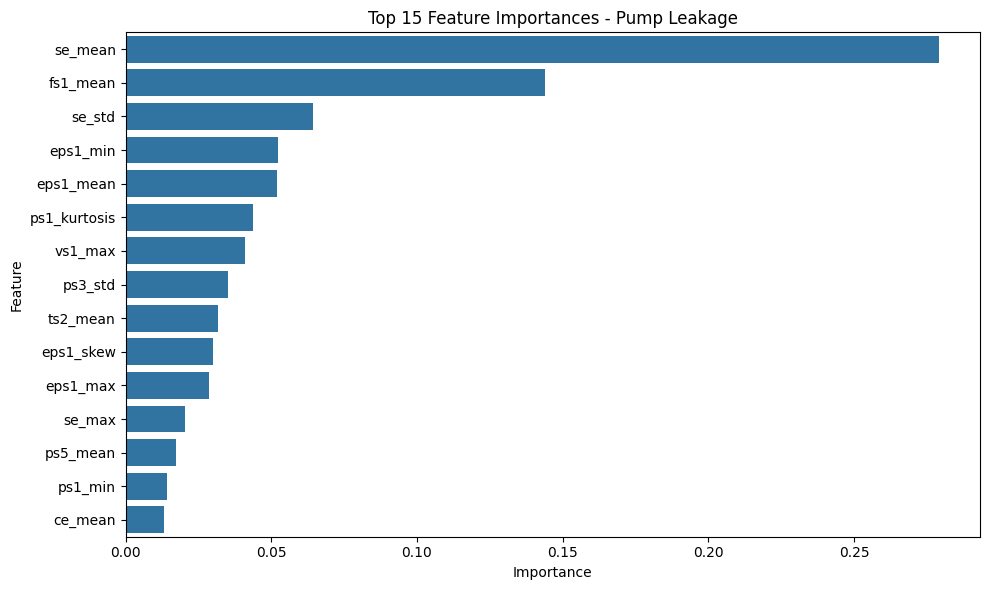

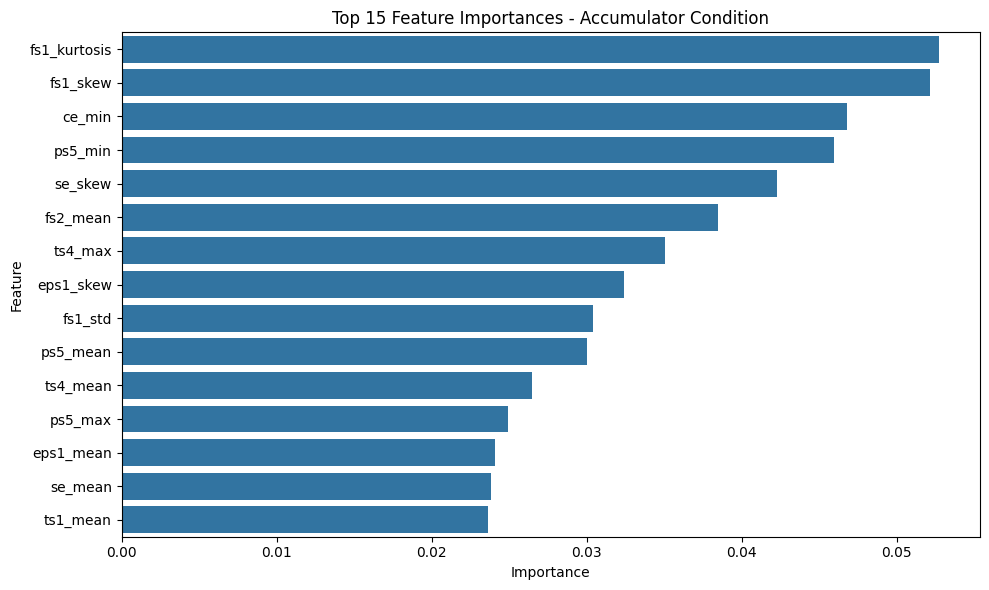

In [46]:
plot_feature_importances(models['cooler'], feature_names, title='Cooler Condition')
plot_feature_importances(models['valve'], feature_names, title='Valve Condition')
plot_feature_importances(models['leakage'], feature_names, title='Pump Leakage')
plot_feature_importances(models['acc'], feature_names, title='Accumulator Condition')